In [1]:
import os,shutil

files = folders = 0
for _, dirnames, filenames in os.walk("../anomaly_karyotype/translocation"):
  # ^ this idiom means "we won't be using this value"
    files += len(filenames)
    folders += len(dirnames)
print ("{:,} files, {:,} folders".format(files, folders))

745 files, 0 folders


In [32]:
dir_names=[]
basicdir="../rawdata/"
savedir="../anomaly_karyotype/normal/"
for _, dirnames, filenames in os.walk("../karyotype_segment"):
    dir_names=dirnames
    break
for d in dir_names:
    if os.path.isdir(basicdir+d):
        dirpath=basicdir+d
        for _, dirnames, filenames in os.walk(basicdir+d):
                for f in filenames:
                    if 'K' in f:
                        shutil.copy(dirpath+'/'+f,savedir+d+f)

In [18]:
import csv
t=inv=add=loss=delete=dup=dic=i=0
ignore=['sample','mos','no','mar','der','/','ish','DEB']
basicdir="../rawdata/"
savedir="../anomaly_karyotype/"
with open('anomaly_csv.csv','r') as myFile:
    lines=csv.reader(myFile)
    for line in lines:
        notation=line[1]
        dirpath=basicdir+line[0]
        if notation=='':
            continue
        if any(s in notation for s in ignore):
            continue
        try:
            chromosome_num=int(notation[:2])
        except(ValueError):
            print(line[0])
#         if chromosome_num>46 or 'add' in notation or '+' in notation:
#             add+=1
#             for _, dirnames, filenames in os.walk(dirpath):
#                 for f in filenames:
#                     if 'K' in f:
#                         shutil.copy(dirpath+'/'+f,savedir+"add/"+line[0]+f)
#         if chromosome_num<46 or '-' in notation:
#             loss+=1
#             for _, dirnames, filenames in os.walk(dirpath):
#                 for f in filenames:
#                     if 'K' in f:
#                         shutil.copy(dirpath+'/'+f,savedir+"loss/"+line[0]+f)
        if 't' in notation:
            t+=1
            for _, dirnames, filenames in os.walk(dirpath):
                for f in filenames:
                    if 'K' in f:
                        shutil.copy(dirpath+'/'+f,savedir+"translocation/"+line[0]+f)
        if 'inv' in notation:
            inv+=1  
            for _, dirnames, filenames in os.walk(dirpath):
                for f in filenames:
                    if 'K' in f:
                        shutil.copy(dirpath+'/'+f,savedir+"inv/"+line[0]+f)         
        if 'del' in notation:
            delete+=1
            for _, dirnames, filenames in os.walk(dirpath):
                for f in filenames:
                    if 'K' in f:
                        shutil.copy(dirpath+'/'+f,savedir+"del/"+line[0]+f)
        if 'dup' in notation:
            dup+=1
            for _, dirnames, filenames in os.walk(dirpath):
                for f in filenames:
                    if 'K' in f:
                        shutil.copy(dirpath+'/'+f,savedir+"dup/"+line[0]+f)
        if 'dic' in notation:
            dic+=1
            for _, dirnames, filenames in os.walk(dirpath):
                for f in filenames:
                    if 'K' in f:
                        shutil.copy(dirpath+'/'+f,savedir+"dic/"+line[0]+f)
        if 'i' in notation:
            i+=1
            for _, dirnames, filenames in os.walk(dirpath):
                for f in filenames:
                    if 'K' in f:
                        shutil.copy(dirpath+'/'+f,savedir+"i/"+line[0]+f)
print('t',t,'inv',inv,'add',add,'loss',loss,'dup',dup,'del',delete,'dic',dic,'i',i)

t 264 inv 66 add 675 loss 90 dup 35 del 161 dic 17 i 103


In [ ]:
# t
# der:derivative,a chromosome with many aberrations
# inv
# del
# dup
# mar:is a small fragment of a chromosome which generally cannot be identified without specialized genomic analysis due to the size of the fragment
# dic:a chromosome with 2 centromes
# i:the arms of the chromosome are mirror images of each other

In [2]:
import numpy as np
import scipy.ndimage as ndi
from skimage import measure,color,morphology
import matplotlib.pyplot as plt
#loss images:238

In [3]:
from skimage import io
from skimage.filters import threshold_otsu, threshold_adaptive
from skimage.morphology import closing, square
from skimage.color import rgb2gray
import skimage.external.tifffile as tif
from skimage.measure import label, regionprops
import os
cur_dir="../anomaly_karyotype/normal"
# cur_file="HK.tif"
save_dir="../karyotype_segment/"
chromo_num={}
file_names=[]
for _, dirnames, filenames in os.walk(cur_dir):
    file_names=filenames
    break

In [ ]:
for f in file_names:
    if f[-7].isdigit() or f[-6].isdigit():
        continue
    print(cur_dir+"/"+f)
    image = tif.imread(cur_dir+"/"+f)
    tif.imshow(image,cmap='gray')
    plt.show()
    width=image.shape[0]
    height=image.shape[1]
    for i in range(width):
        for j in range(height):
            if image[i][j][0]==255 and image[i][j][1]==0 and image[i][j][2]==0:
                image[i][j]=[255,255,255]
    grayscale = rgb2gray(image)
    block_size = 49
    binary_adaptive = ~threshold_adaptive(grayscale, block_size, offset=0)
    out2=morphology.remove_small_objects(binary_adaptive,min_size=100,connectivity=1)
    out2c= closing(out2, square(4))
    labels=measure.label(out2c,connectivity=2)  #8连通区域标记
    regions = regionprops(labels)
    name=f[:5]
    newregions=sorted(regions,key=lambda x:x.bbox[1])
    num=len(regions)
    for i in range(len(regions)-1):
        minr1,c1,maxr1,maxc1=newregions[i].bbox
        minr2,c2,maxr2,maxc2=newregions[i+1].bbox
        if c2-c1<=10 and abs(minr1-minr2)<50:
            num-=1
    if name not in chromo_num:
        chromo_num[name]=num
    elif num>=45:
        chromo_num[name]=min(chromo_num[name],num)
    else:
        continue

In [10]:
for _, dirnames, filenames in os.walk(cur_dir):
    print(len(filenames))

1145
0


In [51]:
normal=[]
add=[]
loss=[]
for k,v in chromo_num.items():
    if v>46:
        add.append(k)
    elif v<46:
        loss.append(k)
    else:
        normal.append(k)
print(len(loss),len(add),len(normal),len(chromo_num))
print(loss)

12 4 72 88
['26159', '26224', '26222', '26225', '26226', '26203', '36428', '26157', '26193', '26125', '26218', '26137']


(512, 768, 3)


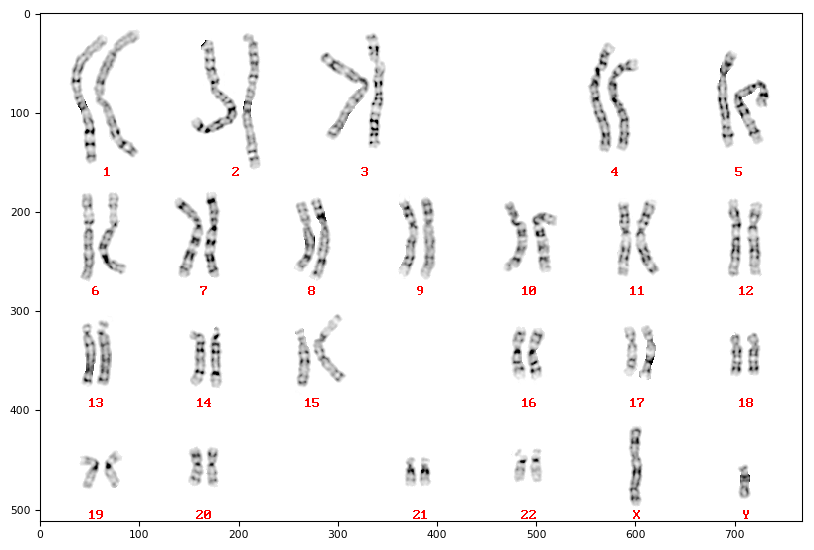

In [10]:
cur_dir="../anomaly_karyotype/normal/"
cur_file="26159PDK.tif"
image = tif.imread(cur_dir+cur_file)
#size not the same
print(image.shape)
tif.imshow(image,cmap='gray');

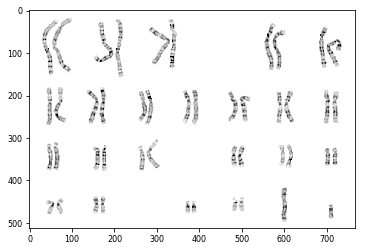

In [11]:
width=image.shape[0]
height=image.shape[1]
for i in range(width):
    for j in range(height):
        if image[i][j][0]==255 and image[i][j][1]==0 and image[i][j][2]==0:
            image[i][j]=[255,255,255]
plt.imshow(image)

/home/hywang/anaconda3/lib/python3.7/site-packages/skimage/filters/thresholding.py:229: skimage_deprecation: Function ``threshold_adaptive`` is deprecated and will be removed in version 0.15. Use ``threshold_local`` instead.
  def threshold_adaptive(image, block_size, method='gaussian', offset=0,
/home/hywang/anaconda3/lib/python3.7/site-packages/skimage/filters/thresholding.py:231: UserWarning: The return value of `threshold_local` is a threshold image, while `threshold_adaptive` returned the *thresholded* image.
  warn('The return value of `threshold_local` is a threshold image, while '


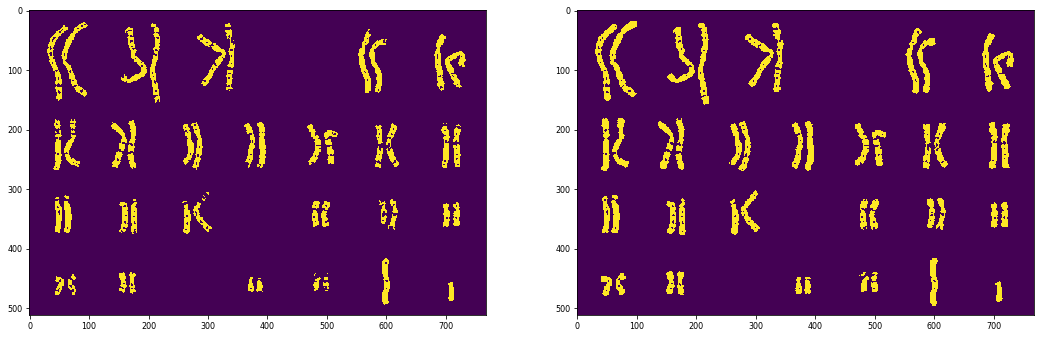

In [12]:
from skimage.filters import threshold_otsu, threshold_adaptive
from skimage.color import rgb2gray
grayscale = rgb2gray(image)
global_thresh = threshold_otsu(grayscale)
binary_global = grayscale < global_thresh
block_size = 49
binary_adaptive = ~threshold_adaptive(grayscale, block_size, offset=0)
fig, (ax1,ax2) = plt.subplots(1, 2,figsize=(18,9))
ax1.imshow(binary_global)
ax2.imshow(binary_adaptive)

In [13]:
out=morphology.remove_small_objects(binary_global,min_size=20,connectivity=1)
out2=morphology.remove_small_objects(binary_adaptive,min_size=100,connectivity=1)

In [14]:
from skimage.morphology import closing, square
out2c= closing(out2, square(4))
labels=measure.label(out2c,connectivity=2)  #8连通区域标记
dst2=color.label2rgb(labels)  #根据不同的标记显示不同的颜色

45


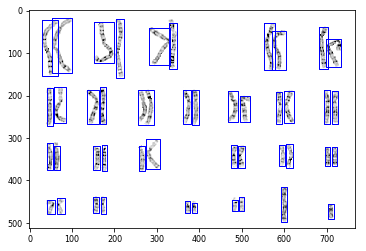

In [15]:
#if 2 boxes row difference<50, col diff<10,
from skimage.measure import label, regionprops
import os
regions = regionprops(labels)
fig, ax = plt.subplots()
ax.imshow(image, cmap=plt.cm.gray)
newregions=sorted(regions,key=lambda x:x.bbox[1])
num=len(regions)
for i in range(len(regions)-1):
    minr1,c1,maxr1,maxc1=newregions[i].bbox
    minr2,c2,maxr2,maxc2=newregions[i+1].bbox
    if c2-c1<=10 and abs(minr1-minr2)<50:
        num-=1
print(num)
for props in regions:
    minr, minc, maxr, maxc = props.bbox
#     print(minr,minc,maxr-minr,maxc-minc)
#     print((maxr-minr)*(maxc-minc))
    bx = (minc, maxc, maxc, minc, minc)
    by = (minr, minr, maxr, maxr, minr)
    ax.plot(bx, by, '-b', linewidth=1)
plt.show()